In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor,plot_importance
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score,mean_squared_error



In [2]:
dfcal = pd.read_csv('calendar.csv')
dflist = pd.read_csv('listings.csv')
dfreview = pd.read_csv('reviews.csv')


In [3]:
dfcal['available'] =dfcal['available'].apply(lambda x: 1 if x =='t' else 0)

dfcal_group = pd.DataFrame(dfcal.groupby(by=['listing_id'])['available'].mean())
dflistindex = dflist.set_index('id')
dflist = pd.concat([dfcal_group, dflistindex], axis = 1)

In [4]:
dflist.head(2)

,available,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3353,0.682192,https://www.airbnb.com/rooms/3353,20160906204935,2016-09-07,Private & Small for Solo Travelers,"Clean and comfortable room, good for short ter...",Hey Traveler! We have a nice apartment about 3...,"Clean and comfortable room, good for short ter...",none,NaN,...,9.0,f,NaN,NaN,f,strict,f,f,2,0.38
5506,0.942466,https://www.airbnb.com/rooms/5506,20160906204935,2016-09-07,$99 Special! Hotel Alternative!,NaN,**THE BEST Value in BOSTON!!*** PRIVATE GUEST ...,**THE BEST Value in BOSTON!!*** PRIVATE GUEST ...,none,"Peacful, Architecturally interesting, histori...",...,10.0,f,NaN,NaN,f,strict,f,f,6,0.40


In [5]:
col_to_use = ['available','host_response_time','host_is_superhost',
       'host_listings_count','host_identity_verified','property_type','neighbourhood_cleansed','room_type',
       'bathrooms','bedrooms','beds','bed_type',
       'guests_included','extra_people','minimum_nights','maximum_nights',
       'availability_30','availability_60','availability_90','availability_365',
       'number_of_reviews','review_scores_rating',
       'require_guest_phone_verification',
       'calculated_host_listings_count','reviews_per_month','amenities','price']




In [6]:
dflist.shape

(3585, 95)

**

---
**

# Preprocessing of Zipcode

Purpose  : **Organizing of Zipcode** <br>
Method   : Before using **One Hot Encoding method**, zip codes that has **less than 60 listings** are assigned to **'02000'** to decrease extra new columns.

In [7]:
zip_columns = list(pd.DataFrame(dflist['zipcode'].value_counts().head(19).index)[0])

dflist['zipcode'] = dflist['zipcode'].apply(lambda x: x if x in zip_columns else '02000')
dflist['zipcode'].value_counts().head()

02000    392
02116    388
02130    331
02118    247
02215    236
Name: zipcode, dtype: int64

**

---
**

# Preprocessing of Price

Purpose  : **Cleaning of Price** Stripping of ` $ ` and decimal point(` .00 `) <br>
Instance : '$250.00'  > string <br>
Goal     :   250      > int

In [8]:
dflist[['price']].head(5)

,price
3353,$40.00
5506,$145.00
6695,$195.00
6976,$65.00
8792,$154.00


In [9]:
dflist['price'][3353][1:-3]

'40'

In [10]:
# Stripping of $ and .00

dflist['price'] = dflist['price'].apply(lambda x: int(x[1:-3].replace(",", "")))


In [11]:
dflist[['price']].sample(5)

,price
8014383,215
957224,275
6758443,150
2722165,299
12890156,149


# Preprocessing of Extra Guest Cost

Purpose  : **Cleaning of 'extra_people'** Stripping of ` $ ` and decimal point(` .00 `) <br>
Instance : '$250.00'  > string <br>
Goal     :   250      > int

'extra_people'

In [12]:
dflist[['extra_people']].head(5)

,extra_people
3353,$0.00
5506,$0.00
6695,$8.00
6976,$20.00
8792,$0.00


In [13]:
dflist['extra_people'][6976]

'$20.00'

In [14]:
# Stripping of $ and .00

dflist['extra_people'] = dflist['extra_people'].apply(lambda x: int(x[1:-3]))


In [15]:
dflist[['extra_people']].sample(5)

,extra_people
7825327,20
4975581,0
13924495,25
4555637,0
1757417,0


**

---
**

# Preprocessing of Amenities

Let's transfer the number of attributes in `  'amenities'  ` to a column. (row based)

In [16]:
# the number of attributes

dflist['amenities'] = dflist['amenities'].apply(lambda x: x.count(',')+1)

# Preprocessing of reviews_per_month

Empty values are most probably  the ones that does not have any comment

In [17]:
dflist['reviews_per_month'].fillna(0, inplace=True)

# Preprocessing of require_guest_phone_verification

In [18]:
# Applying with true_false function

dflist['require_guest_phone_verification'] = dflist['require_guest_phone_verification'].apply(
    lambda x: 1 if x =='t' else 0) 


In [19]:
dflist['host_identity_verified'] = dflist['host_identity_verified'].apply(
    lambda x: 1 if x =='t' else 0) 

# Preprocessing of host_is_superhost


In [20]:
dflist['host_is_superhost']=dflist['host_is_superhost'].apply(lambda x : 1 if x=='t' else 0)

# Preporocessing to property_type

Purpose  : **Organizing of List Property Type** <br>
Method   : Before using **One Hot Encoding method**, the property type needs decrease of columns.

- ['Camper/RV','Bed & Breakfast','Entire Floor','Boat','Guesthouse'] convert to 'Other'
- ['Villa','Townhouse'] convert to 'House'
- ['Condominium','Loft'] convert to 'Apartment'

In [21]:
dflist['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

In [22]:
def house(z):
    if z in ['Camper/RV','Bed & Breakfast','Entire Floor','Boat','Guesthouse']:
        return 'Other House'
    elif z in ['Villa','Townhouse']:
        return 'House'
    elif z in ['Condominium','Loft','Dorm']:
        return 'Apartment'
    else:
        return z

In [23]:
dflist['property_type'] = dflist['property_type'].apply(house)

# Preporocessing to bed_type

Purpose  : **Organizing of List Bed Type** <br>
Method   : Before using **One Hot Encoding method**, the bed type inside of rooms needs decrease of columns.

- ['Futon', 'Air Bed', 'Couch', 'Sofa'] convert to 'Other'


In [24]:
dflist['bed_type'].value_counts()

Real Bed         3453
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64

In [25]:
def bed(b):
    if b == 'Real Bed':
        return 'Real Bed'
    else:
        return 'Other'

In [26]:
dflist['bed_type'] = dflist['bed_type'].apply(bed)

# Preprocessing of host_listings_count
Purpose : Calculate of Business Category from host_listings_count<br>
Method : Because of Outliers values are grouped.


In [27]:
def bus_ind(z):
    if z <= 13:
        return 0
    elif z >13 and  z <= 55 :
        return 1
    else:
        return 2

    
dflist['host_listings_count'] =dflist['host_listings_count'].apply(bus_ind)

In [28]:
dflist['host_listings_count'].sample(5)

22212       2
12130434    2
442735      0
14566657    0
14683493    0
Name: host_listings_count, dtype: int64

In [29]:
dflist=dflist[col_to_use]
dflist.head()

,available,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,property_type,neighbourhood_cleansed,room_type,bathrooms,bedrooms,...,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities,price
3353,0.682192,within a few hours,0,0,1,Apartment,Allston,Private room,1.0,1.0,...,0,0,249,34,90.0,0,2,0.38,11,40
5506,0.942466,within a day,0,0,1,House,Roxbury,Private room,1.0,1.0,...,39,69,344,36,91.0,0,6,0.40,8,145
6695,0.887671,within a day,0,0,1,Apartment,Roxbury,Entire home/apt,1.0,1.0,...,19,49,324,47,95.0,0,6,0.54,18,195
6976,0.873973,within a few hours,1,0,1,Apartment,Roslindale,Private room,1.0,1.0,...,46,61,319,41,98.0,0,1,0.47,18,65
8792,0.679452,within a few hours,0,0,0,Apartment,Downtown,Entire home/apt,1.0,1.0,...,0,0,248,18,91.0,0,10,0.21,9,154


# IMPUTATION  for MISSING VALUES

In [30]:
rooms = ['bedrooms','bathrooms','beds']
for i in rooms:
    dflist[i].fillna(value =0, inplace =True)

In [31]:
dflist['property_type'].fillna('Apartment', inplace=True)

In [32]:
dflist['host_response_time'].fillna(method='ffill', inplace =True)

In [33]:
# These imputation is done as avg 63 due to host that had reviews less than 10 times had average 63. 
dflist['review_scores_rating'].fillna(63, inplace =True)

In [34]:
dflist.isna().sum().sort_values()

available                           0
reviews_per_month                   0
calculated_host_listings_count      0
require_guest_phone_verification    0
review_scores_rating                0
number_of_reviews                   0
availability_365                    0
availability_90                     0
availability_60                     0
availability_30                     0
maximum_nights                      0
minimum_nights                      0
amenities                           0
extra_people                        0
bed_type                            0
beds                                0
bedrooms                            0
bathrooms                           0
room_type                           0
neighbourhood_cleansed              0
property_type                       0
host_identity_verified              0
host_listings_count                 0
host_is_superhost                   0
host_response_time                  0
guests_included                     0
price       

In [35]:
dflist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 3353 to 14933461
Data columns (total 27 columns):
available                           3585 non-null float64
host_response_time                  3585 non-null object
host_is_superhost                   3585 non-null int64
host_listings_count                 3585 non-null int64
host_identity_verified              3585 non-null int64
property_type                       3585 non-null object
neighbourhood_cleansed              3585 non-null object
room_type                           3585 non-null object
bathrooms                           3585 non-null float64
bedrooms                            3585 non-null float64
beds                                3585 non-null float64
bed_type                            3585 non-null object
guests_included                     3585 non-null int64
extra_people                        3585 non-null int64
minimum_nights                      3585 non-null int64
maximum_nights                   

In [36]:
dflist['neighbourhood_cleansed'].isnull().sum()

0

In [37]:
dflist['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Bay Village                 24
Mattapan                    24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

In [38]:
df_num = dflist.corr()
df_num

,available,host_is_superhost,host_listings_count,host_identity_verified,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,...,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities,price
available,1.000000,0.052608,0.123242,0.079859,0.043548,0.023669,0.054633,0.071025,0.085843,0.021936,...,0.557093,0.630592,1.000000,0.192289,0.042377,0.126633,0.077176,0.071551,-0.011837,0.036694
host_is_superhost,0.052608,1.000000,-0.145977,0.135026,0.046433,0.032916,0.018874,0.096572,0.099407,-0.024151,...,-0.062195,-0.035331,0.052608,0.260565,0.258300,0.000332,-0.117603,0.216250,0.152467,0.006054
host_listings_count,0.123242,-0.145977,1.000000,0.224620,0.173120,0.111907,0.059904,-0.103003,-0.178615,0.073458,...,0.428054,0.391236,0.123242,-0.156501,-0.179785,0.362284,0.857651,-0.202253,0.108256,0.169799
host_identity_verified,0.079859,0.135026,0.224620,1.000000,0.069778,0.051290,0.040193,0.050380,0.026779,-0.003864,...,0.118416,0.129912,0.079859,0.150444,0.177312,0.138245,0.202940,0.101687,0.174005,0.002059
bathrooms,0.043548,0.046433,0.173120,0.069778,1.000000,0.428332,0.351544,0.113320,-0.004507,0.022782,...,0.099131,0.082008,0.043548,-0.034615,-0.016750,0.033489,0.162420,-0.049074,0.135790,0.248695
bedrooms,0.023669,0.032916,0.111907,0.051290,0.428332,1.000000,0.709336,0.395900,0.081634,-0.004623,...,0.072259,0.055887,0.023669,-0.042396,0.019552,0.053797,0.091735,-0.054208,0.214773,0.382418
beds,0.054633,0.018874,0.059904,0.040193,0.351544,0.709336,1.000000,0.477339,0.154741,-0.019494,...,0.065030,0.062536,0.054633,-0.007961,0.044188,0.057165,0.027354,0.009151,0.233736,0.371407
guests_included,0.071025,0.096572,-0.103003,0.050380,0.113320,0.395900,0.477339,1.000000,0.415182,-0.029542,...,0.002875,0.027438,0.071025,0.064606,0.101804,-0.016865,-0.104020,0.075342,0.188842,0.211806
extra_people,0.085843,0.099407,-0.178615,0.026779,-0.004507,0.081634,0.154741,0.415182,1.000000,-0.038648,...,0.067544,0.079273,0.085843,0.091102,0.121595,-0.025288,-0.167448,0.086225,0.122199,0.028703
minimum_nights,0.021936,-0.024151,0.073458,-0.003864,0.022782,-0.004623,-0.019494,-0.029542,-0.038648,1.000000,...,0.040637,0.030873,0.021936,-0.062465,-0.043934,0.034086,0.067150,-0.099055,-0.026602,0.020054


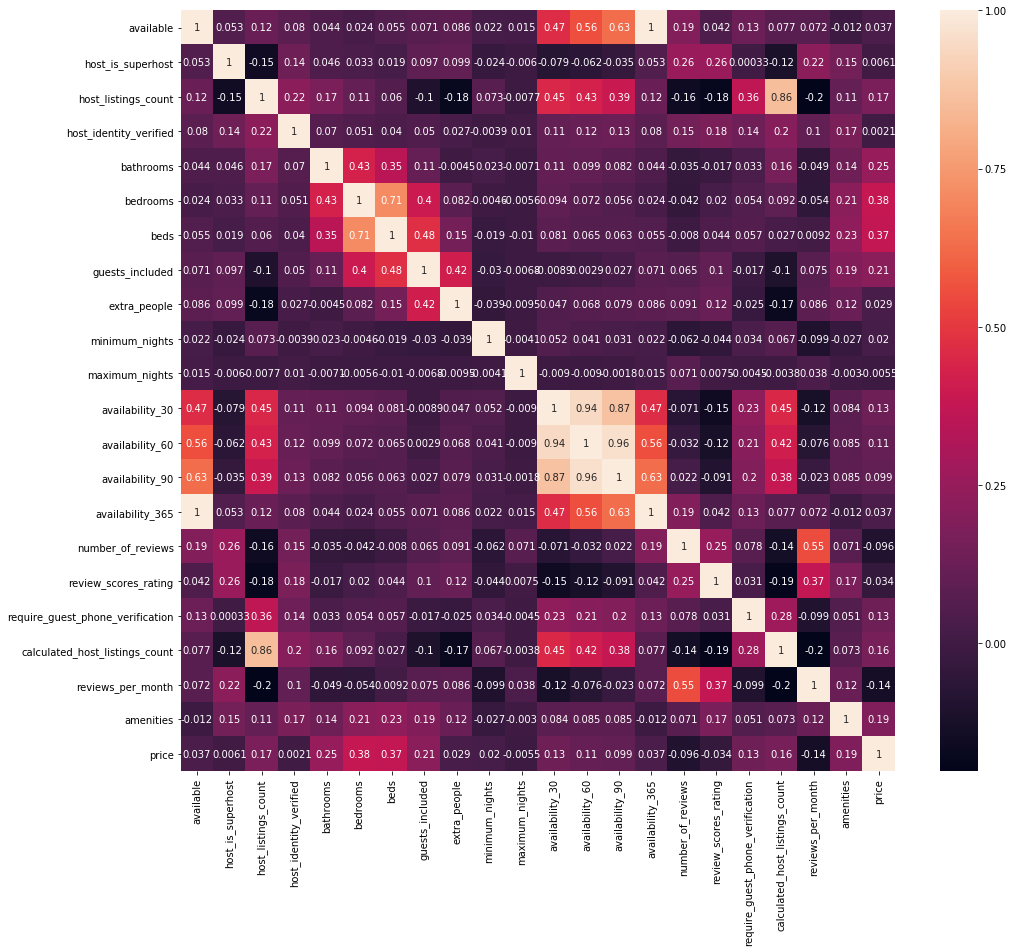

In [39]:
plt.figure(figsize=(16,14))
sns.heatmap(df_num, annot =True)
plt.show()

In [40]:
# GET DUMMIES

dflist_cat_col  =  dflist.select_dtypes(include='object').columns
dflist_cat  =  dflist.select_dtypes(include='object')

dflist_cat.sample(3)

,host_response_time,property_type,neighbourhood_cleansed,room_type,bed_type
9834532,within a few hours,House,Roxbury,Entire home/apt,Real Bed
14849141,within an hour,Apartment,Charlestown,Private room,Real Bed
1587540,within a few hours,House,Charlestown,Entire home/apt,Real Bed


In [41]:
dflist = pd.get_dummies(dflist, drop_first=True)
dflist.shape

(3585, 55)

In [42]:
dflist.head()

,available,host_is_superhost,host_listings_count,host_identity_verified,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,...,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,room_type_Private room,room_type_Shared room,bed_type_Real Bed
3353,0.682192,0,0,1,1.0,1.0,1.0,1,0,7,...,0,0,0,0,0,0,0,1,0,1
5506,0.942466,0,0,1,1.0,1.0,1.0,2,0,3,...,0,1,0,0,0,0,0,1,0,1
6695,0.887671,0,0,1,1.0,1.0,2.0,2,8,3,...,0,1,0,0,0,0,0,0,0,1
6976,0.873973,1,0,1,1.0,1.0,1.0,1,20,3,...,1,0,0,0,0,0,0,1,0,1
8792,0.679452,0,0,0,1.0,1.0,1.0,0,0,30,...,0,0,0,0,0,0,0,0,0,1


In [43]:
corr= pd.DataFrame(dflist.corr().unstack().sort_values().drop_duplicates(), columns=['Corr_value'])

In [44]:
corr[corr['Corr_value']>0.5]

,,Corr_value
number_of_reviews,reviews_per_month,0.552690
availability_60,availability_365,0.557093
available,availability_60,0.557093
availability_365,availability_90,0.630592
available,availability_90,0.630592
bedrooms,beds,0.709336
host_listings_count,calculated_host_listings_count,0.857651
availability_90,availability_30,0.870167
availability_60,availability_30,0.941706
availability_90,availability_60,0.964731


In [45]:
# DROP these two below column due to collinearity
dflist.drop(['availability_60','availability_90','beds','reviews_per_month','host_listings_count'],
            axis=1, inplace =True)

# HEATMAP
plt.figure(figsize=(16,14))
sns.heatmap(dflist.corr(), annot =True)
plt.show()

In [46]:
corr2= pd.DataFrame(dflist.corr().unstack().sort_values().drop_duplicates(), columns=['Corr_value'])
corr2[corr2['Corr_value']>0.5]

Corr_value
available availability_365         1.0
          available                1.0

In [47]:

dflist = dflist[dflist['price']<400]
dflist.shape

(3441, 50)

### TRAIN TEST SPLIT

In [48]:
lr_coef_list = ['price','extra_people','maximum_nights','host_response_time_within a few hours',
                'property_type_House']

In [49]:
y = dflist['price']
X_df = dflist.drop(lr_coef_list, axis = 1)
X = X_df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)


### STANDARD SCALING

In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_X_train = sc.fit_transform(X_train)
sc_X_test  = sc.transform(X_test)

### LINEAR REGRESSION


In [51]:
lr = LinearRegression()
lr.fit(sc_X_train,y_train)

y_train_pred = lr.predict(sc_X_train)
y_test_pred = lr.predict(sc_X_test)

#print(lr.score(y_test_pred,y_test))
print('test prediction score  =',r2_score(y_test,y_test_pred))
print('train prediction score =',r2_score(y_train,y_train_pred))

test prediction score  = 0.6832325323425001
train prediction score = 0.6690997048285663


### RANDOM FOREST REGRESSOR

In [52]:

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

#print(lr.score(y_test_pred,y_test))
print('test prediction score  =',r2_score(y_test,y_test_pred))
print('train prediction score =',r2_score(y_train,y_train_pred))

test prediction score  = 0.7002465219853902
train prediction score = 0.955700421557409


In [53]:
#k-fold cross validation 
from sklearn.model_selection import cross_val_score
''' 
1. estimator : rf
2. X
3. Y
4. cv = 4

'''
success = cross_val_score(estimator = rf, X= X_train, y= y_train , cv = 4)
print(success.mean())
print(success.std())

0.6584193532842295
0.014913680234817095


# XGBOOST

In [55]:
xgb = XGBRegressor(silent=1, objective='reg:gamma', booster='gbtree')
xgb.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

#print(lr.score(y_test_pred,y_test))
print('test prediction score  =',r2_score(y_test,y_test_pred))
print('train prediction score =',r2_score(y_train,y_train_pred))
\

/Users/tacettinarici/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


test prediction score  = 0.7002465219853902
train prediction score = 0.955700421557409


### COEEFICIENT OF FEATURES WITH TARGET VALUE
We can see the effect of features on target value as 1 unit of increase changes how much the target value

In [54]:
coeffecients = pd.DataFrame(lr.coef_,X_df.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
available,-8.067583e+14
host_is_superhost,2.649521e+00
host_identity_verified,-6.630329e-02
bathrooms,2.820205e+00
bedrooms,2.472586e+01
guests_included,5.706005e+00
minimum_nights,-3.551608e+00
availability_30,8.416723e+00
availability_365,8.067583e+14
number_of_reviews,-5.868718e+00


### GRID SEARCH


parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf'),'gamma':('scale')})
sorted(clf.cv_results_.keys())